In [13]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
)

##### Задание 1

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Есть ли в данных пропущенные значения?

In [7]:
df = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [12]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [8]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [9]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [11]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

##### Задание 2

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)
Выберите верные утверждения:

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

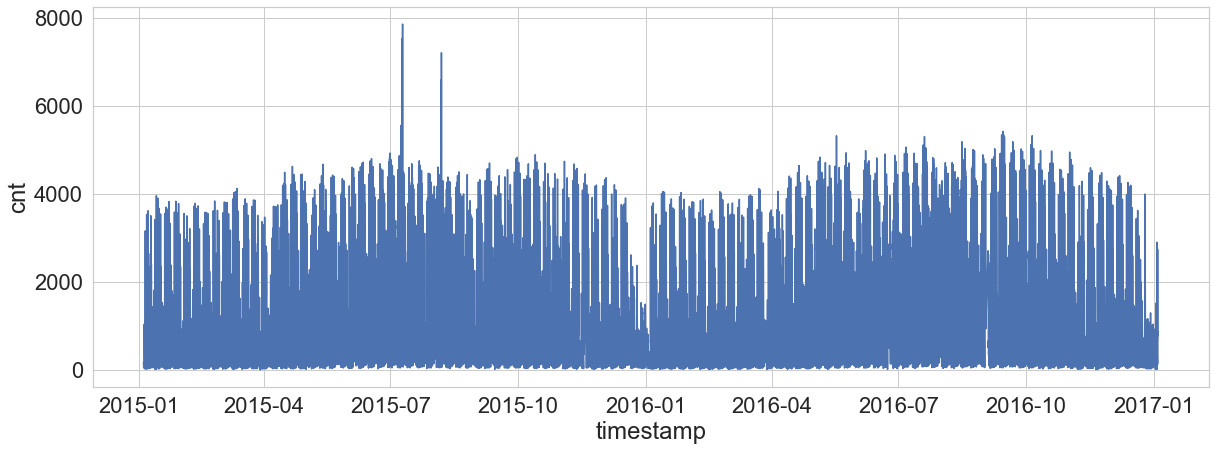

In [18]:
sns.lineplot(data=df, x='timestamp', y='cnt')

##### Задание 3

Отлично! Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:
<pre>
<code>
data.resample(rule='D').column_name.sum() #способ 1
data.resample(rule='D').agg({'column_name':'sum'}) #способ 2, эквивалентный предыдущему
</code>
</pre>
Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?

In [63]:
df_resampled_by_day = df.resample(rule='D', on='timestamp').cnt.sum().reset_index()

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

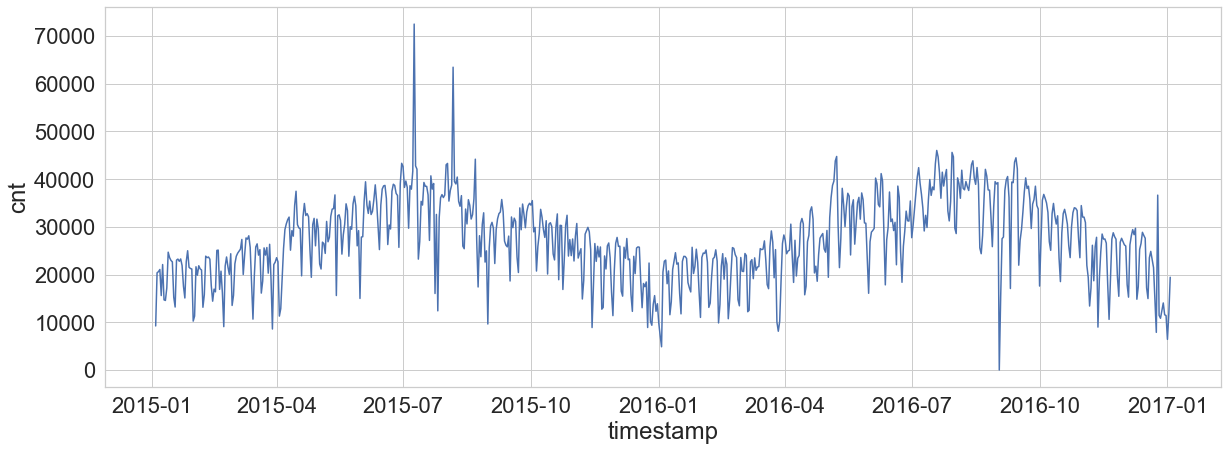

In [22]:
sns.lineplot(data=df_resampled_by_day, x='timestamp', y='cnt')

##### Задание 4

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день 🤔.

Для этого разделим дальнейшие действия на несколько этапов:

* сначала посчитаем скользящее среднее, чтобы сгладить ряд
* далее – разницу между наблюдаемыми и сглаженными значениями
* определим верхние и нижние границы 99% доверительного интервала 
* найдем причины аномалий!

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [64]:
df_resampled_by_day['roll_mean'] = df_resampled_by_day.rolling(on='timestamp', window=3).cnt.mean()

In [69]:
df_resampled_by_day.query('timestamp == "2015-07-09"')

,timestamp,cnt,roll_mean,diff_v
186,2015-07-09,72504,50705.0,21799.0


##### Задание 5

Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения. Например:
<pre>
<code>
c = a - b
std = np.std(c)
</code>
</pre>
В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [73]:
df_resampled_by_day['diff_v'] = df_resampled_by_day.cnt.subtract(df_resampled_by_day.roll_mean)

In [77]:
std_v = np.std(df_resampled_by_day.diff_v)
round(std_v,2)

4558.59

#### Задание 6

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:
<pre>
<code>
upper_bound – верхняя граница; к средним прибавляем 2.576∗std
lower_bound – нижняя граница; вычитаем 2.576∗std
</code>
</pre>
Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

Note: в качестве std нужно брать стандартное отклонение без округления.

Note 2: вам может понадобиться убрать даты из индекса - иногда из-за этого колонки могут не присваиваться в датафрейм. Вам пригодится .reset_index().

In [78]:
koef_99 = 2.576
df_resampled_by_day['upper_bound'] = df_resampled_by_day.roll_mean + koef_99 * std_v
df_resampled_by_day['lower_bound'] = df_resampled_by_day.roll_mean - koef_99 * std_v

In [87]:
df_resampled_by_day.tail(1).upper_bound.round(2)

730    24302.92
Name: upper_bound, dtype: float64

#### Задание 7

И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? Укажите дату в формате 2020-12-31.

In [92]:
df_max = df_resampled_by_day.query('cnt > upper_bound').sort_values(by='cnt', ascending=False)
df_max

,timestamp,cnt,roll_mean,diff_v,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812


#### Задание 8

Подумайте, в чем может быть причина столь высокого числа аренд в этот день. Для этого можете исследовать уже имеющиеся переменные в датасете, проверить наличие ошибок в данных (повторяющихся строк), а также использовать поиск Google. 

В качестве ответа выберите наиболее вероятную причину столь резкого скачка:

##### Задание 9

Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

In [108]:
df_min = df_resampled_by_day.query('cnt < lower_bound').sort_values(by='cnt', ascending=False)
df_min

,timestamp,cnt,roll_mean,diff_v,upper_bound,lower_bound
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146


In [123]:
df.query('timestamp > "2016-09-02" and timestamp < "2016-09-03"')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date
